# Assignment 3 : CNN Visualization


이번 과제에서는 강의 6에서 공부했던 다양한 방식의 CNN visualization 방법들을 직접 구현해봅니다. Assignment 1과 2에서 사용했던 customed-VGG11 모델을 분석해보며, CNN 모델의 동작과 학습 원리에 대한 좋은 직관을 갖게 되셨으면 좋겠습니다. 

Special thanks: This PA design is inspired from PA5 of Cornell CS5670 (By Noah Snavely and Abe Davis). 

## **Notes on PyTorch**
Many operations are implemented on Tensors (e.g, torch.FloatTensor or torch.LongTensor) in PyTorch, as on ndarray in numpy. One can compute operations like arithmetics, and will get a new Tensor as an output. 

Also, Variables (e.g, torch.autograd.Variable) wrap tensors and can be used interchangeably as Tensors. Like Tensors, with operation on Variable, the output is a new Variable.

Here, Pytorch autograd builds a computational graph with operations on Tensors (involving Variables), with True requires_grad parameter. This indicates to compute gradients of that Tensors w.r.t. the other Tensors 'automatically' with calling backward. 

With such option, one can calculate the gradient w.r.t. model parameters by calling backward on the loss function we're trying to optimize, allowing us to implement 'gradient descent'. Furthremore, one can call backward to calculate the gradient w.r.t the input. 

One can access to the gradients (after calling backward) as the .grad attribute of the Tensor.

##**Google Drive Mount**
해당 문제를 풀기 위해서는 (1) pretrained model 과 (2) 저희가 선별한 inference용도의 data가 따로 필요합니다. 과제 폴더에 해당 데이터들을 넣어드렸는데요. "드라이브에 바로가기 추가" 옵션을 활용하여 내 드라이브로 바로가기를 추가하신 후, 아래의 코드들을 돌려서 colab 작업 환경에 파일들을 잘 copy 하시기 바랍니다.

    
***Inference를 위해 사용하는 data들에는 저작권 문제가 있으니, 공지된 저작권 관련 policy를 잘 따라주셔야 합니다.***

    
혹시라도 cp가 제대로 안되는 경우 모델/데이터 로딩이 안되실 겁니다. 그럴 땐, 밑에 cp command의 source path를 알맞게 고쳐주시면 됩니다. 가령, 과제 폴더 전체를 바로가기로 추가하실 경우 source path를 ./MyDrive/MyDrive/과제3/Assignment3_model_pretrinaed.pth 등으로 고쳐주시면 됩니다.

!cp <U>[source path]</U> [destination path]

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Drive already mounted at ./MyDrive; to attempt to forcibly remount, call drive.mount("./MyDrive", force_remount=True).


In [ ]:
!cp ./MyDrive/Shareddrives/UpstageCV21/Assignment3/Assignment3_model_pretrained.pth ./model.pth

In [ ]:
!cp -R ./MyDrive/Shareddrives/UpstageCV21/Assignment3/Assignment3_data ./data

## **Utils**
Cells below implement useful functions that will be used in this assignment

### Utils (module)

In [ ]:
from os import path
import wheel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import functools
import urllib
import cv2
import numpy as np
import os
import sys
import math
import random
import matplotlib.pyplot as plt
from glob import glob
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO

import PIL.Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

### Utils (image converter)

In [ ]:
def image_tensor_to_numpy(tensor_image):
  # If this is already a numpy image, just return it
  if type(tensor_image) == np.ndarray:
    return tensor_image
  
  # Make sure this is a tensor and not a variable
  if type(tensor_image) == Variable:
    tensor_image = tensor_image.data
  
  # Convert to numpy and move to CPU if necessary
  np_img = tensor_image.detach().cpu().numpy()
  
  # If there is no batch dimension, add one
  if len(np_img.shape) == 3:
    np_img = np_img[np.newaxis, ...]
  
  # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
  np_img = np_img.transpose(0, 2, 3, 1)
  
  return np_img

def image_numpy_to_tensor(np_image):
  if len(np_image.shape) == 3:
    np_image = np_image[np.newaxis, ...]
  
  # Convert from BxHxWxC (OpenCV/numpy) to BxCxHxW (PyTorch)
  np_image = np_image.transpose(0, 3, 1, 2)
  
  tensor_image = torch.from_numpy(np_image).float()
  
  return tensor_image

### Utils (image drawer)

In [ ]:
def normalize(tensor):
  x = tensor - tensor.min()
  x = x / (x.max() + 1e-9)
  return x

def draw_border(image_np, color):
  color = np.asarray(color)
  s = image_np.shape
  image_np = image_np.copy()
  image_np[0:5, :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, 0:5, :] = color[np.newaxis, np.newaxis, :]
  image_np[s[0]-5:s[0], :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, s[0]-5:s[0], :] = color[np.newaxis, np.newaxis, :]
  return image_np

def show_image(image, title=None):
  np_img = image_tensor_to_numpy(image)
  if len(np_img.shape) > 3:
    np_img = np_img[0]
  np_img = normalize(np_img)
  
  # plot 
  np_img = np_img.squeeze()
  plt.figure(figsize=(4,4))
  plt.imshow(np_img)
  plt.axis('off')
  if title: plt.title(title)
  plt.show()
    
def show_images(image_list):
  for l in image_list:
    f, axarr = plt.subplots(1,len(l))
    for i,img in enumerate(l):
      np_img = image_tensor_to_numpy(img)
      if len(np_img.shape) > 3:
        np_img = np_img[0]
      np_img = normalize(np_img)

      np_img = np_img.squeeze()
      axarr[i].imshow(np_img)
      axarr[i].axis('off')
    plt.show()

## **Model definition**
Below are the cells implementing customed-VGG11 for this assignment. You have seen this architecture in assignment_1.1. We have modified the skeleton codes slightly to access modules directly by defining the shortcut_modules attribute.

In [ ]:
class VGG11BackBone(nn.Module):
  def __init__(self):
    super(VGG11BackBone, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)

    return x

class VGG11Classification(nn.Module):
  def __init__(self, num_classes = 7):
    super(VGG11Classification, self).__init__()

    self.backbone = VGG11BackBone()
    self.gap      = nn.AdaptiveAvgPool2d(1)
    self.fc_out   = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.backbone.pool5(x)

    x = self.gap(x)
    x = torch.flatten(x, 1)
    x = self.fc_out(x)

    return x

In [ ]:
model_root = './model.pth'

model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

<All keys matched successfully>

## **Dataset**

The cell below implements a dataset that loads the images being used in this assignment. This allows easy way of loading data in multiple background threads without writing any threading code. Here, __len__ and __getitem__ stand for length of the dataset and samples from the dataset can be obtained by indexing it like sample = dataset[index], respectively.


In [ ]:
# Dataset
class MaskDataset(Dataset):
  def __init__(self, data_root, input_size=224, transform=None, shuffle=False):
    super(MaskDataset, self).__init__()

    self.img_list = sorted(glob(os.path.join(data_root, '*.jpg')))
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
  
    # Image Loading
    img = cv2.imread(img_path)
    img = img/255.

    if self.transform:
      img = self.transform(img)

    return img

  def __len__(self):
    return self.len

In [ ]:
data_root = './data'

input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

mask_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)

## **Problem 2-1**

The code below implements visualizing model structure. Please fill in  3 **TO DO**s and check the following answers with **calc_answer** functions below.


- **TO DO (1)** : You should fill in function **get_params_num** which returns the number of parameters in a given module.

- **TO DO (2)** : You should get **conv1_filters_data** from the model.

- **TO DO (3)** : You should register a hook function of activation drawing to visualize them on the target layer.

- **Hint** : You may use the functions below to fill in Todo's:    
(1) module.register_forward_hook    
(2) Tensor.weight.data    
(3) torch.size()    


### **Visualizing Structure**
The customed-VGG11 model consists of 8 convolutional layers and 1 fully connected layer. We can analyze the shapes of the model parameters using the function below

In [ ]:
def get_module_params_num(module):
  """
  Return the parameter number of modules
  With parameter in module in shape of (H,W,D), the size of such parameter would be HxWxD

  Keyword arguments:
  module: the module is composed of several named parameters
  """
  param_num = 0

  for _, param in module.named_parameters():
    
    '''==========================================================='''
    '''======================== TO DO (1) ========================'''

    param_size = 1
    for size in list(param.size()):
      param_size *= size
    param_num += param_size

    '''==========================================================='''
    '''======================== TO DO (1) ========================'''

  return param_num

def get_model_params_num(model):
  module_num = 0
  for name, module in model._modules.items():
    module_num += get_module_params_num(module)
  return module_num

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

for name, module in model.named_parameters():
  names = name.split(".")
  if "backbone" in name:
    n = names[1]
  else:
    n = names[0]

  if "weight" in name :
    print(f"** Module {n} **\n"
          f"weights: {module.size()}")
  if "bias" in name :
    print(f"bias: {module.size()}\n")

** Module conv1 **
weights: torch.Size([64, 3, 3, 3])
bias: torch.Size([64])

** Module bn1 **
weights: torch.Size([64])
bias: torch.Size([64])

** Module conv2 **
weights: torch.Size([128, 64, 3, 3])
bias: torch.Size([128])

** Module bn2 **
weights: torch.Size([128])
bias: torch.Size([128])

** Module conv3_1 **
weights: torch.Size([256, 128, 3, 3])
bias: torch.Size([256])

** Module bn3_1 **
weights: torch.Size([256])
bias: torch.Size([256])

** Module conv3_2 **
weights: torch.Size([256, 256, 3, 3])
bias: torch.Size([256])

** Module bn3_2 **
weights: torch.Size([256])
bias: torch.Size([256])

** Module conv4_1 **
weights: torch.Size([512, 256, 3, 3])
bias: torch.Size([512])

** Module bn4_1 **
weights: torch.Size([512])
bias: torch.Size([512])

** Module conv4_2 **
weights: torch.Size([512, 512, 3, 3])
bias: torch.Size([512])

** Module bn4_2 **
weights: torch.Size([512])
bias: torch.Size([512])

** Module conv5_1 **
weights: torch.Size([512, 512, 3, 3])
bias: torch.Size([512])

*

In [ ]:
num_params = get_model_params_num(model)
print(f"Number of parameters in customed-VGG11: {num_params}")

Number of parameters in customed-VGG11: 9229575


### **Visualizing conv1 filters**
The first convolutional layer (i.e., conv1 filters) is unique since they take the input image in the form of RGB matrix. In other words, we can convert and visualize such filters as RGB images. Note that it is hard to visualize filters for all other layers as nice as the first convolutional layer, because they are in much higher dimension.


In [ ]:
def plot_filters(data, title=None):
    """
    Take a Tensor of shape (n, K, height, width) or (n, K, height, width)
    and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    """
    
    if data.size(1) > 3:
      data = data.view(-1, 1, data.size(2), data.size(3))
        
    data = image_tensor_to_numpy(data)
        
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 2), (0, 2))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = data.squeeze()
    
    # plot it
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(title)
    plt.imshow(data)

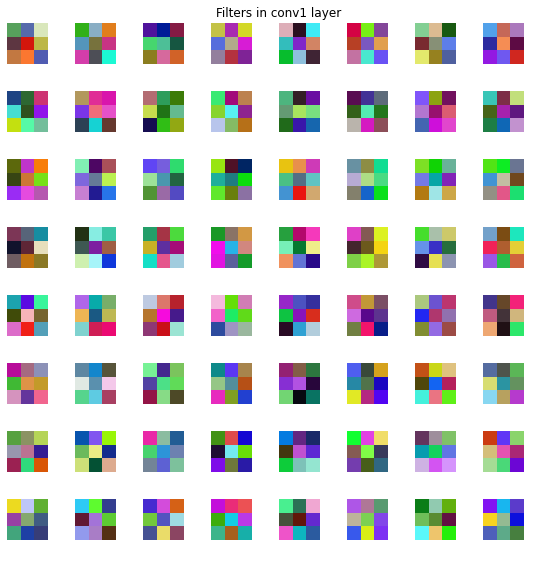

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

'''==========================================================='''
'''======================== TO DO (2) ========================'''

conv1_filters_data = model.backbone.conv1.weight.data

'''==========================================================='''
'''======================== TO DO (2) ========================'''

plot_filters(conv1_filters_data, title="Filters in conv1 layer")

#### **Discussion**
WIth current **customed-VGG11** model, it is hard to see how the filters would behave, becuase of small kernel size. You may compare them with the filters of **AlexNet** (introduced during lecture), and consider how those filters act differently.

### **Visualizing model activations**
With hooks (in PyTorch), one can get data in the intermediate layers while passing the input. 

For example, with forward hook, a function will get called every time that the forward method on a module has been executed. Registering visualization function will enable us to analyze the activation of each layers.

In [ ]:
plot_activations = plot_filters

In [ ]:
activation_list = []

def show_activations_hook(name, module, input, output):
  # conv/relu layer outputs (BxCxHxW)
  if output.dim() == 4:
    activation_list.append(output)
    plot_activations(output, f"Activations on: {name}")

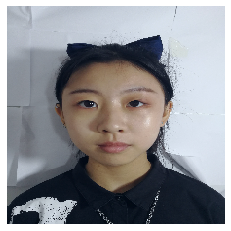

In [ ]:
# Image preparation
img = mask_dataset[0]
show_image(img)
img = Variable(img[np.newaxis, ...])
img = img.double()

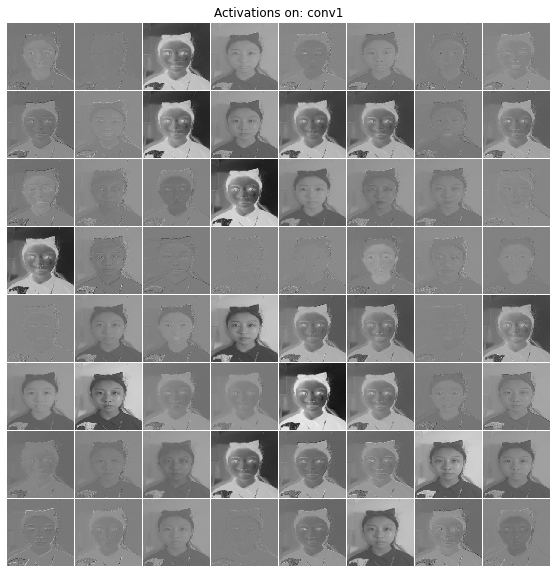

In [ ]:
# Re-define the model to clear any previously registered hooks
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

# Register the hook on the select set of modules
module_list  = [model.backbone.conv1]
module_names = ["conv1"]

'''==========================================================='''
'''======================== TO DO (3) ========================'''

for idx, (name, module) in enumerate(zip(module_names, module_list)):
  hook = functools.partial(show_activations_hook, name)
  module.register_forward_hook(hook)

'''==========================================================='''
'''======================== TO DO (3) ========================'''

_ = model(img)

In [ ]:
np.shape(activation_list[0])

torch.Size([1, 64, 224, 224])

#### **Discussion**

You may analyze activations in different modules by modifying **module_list**. Check how different activations are between layers near input and near output.

## **Problem 2-2**

The code below implements visualizing saliency map. Please fill in  1 **TO DO** and check the following answers with **calc_answer** functions below.


- **TO DO (4)** : You should fill in function **compute_gradient_score** which returns the gradient of s_y (the score at index class_idx) w.r.t the input image (data), ds_y / dI.


- **Hint** : Consider what kind of information should go backward to compute it.

### **Visualizing saliency**
Using pre-trained customed-VGG11 model, one can get class saliency maps, described in Section 3.1 of [1]. Following Section 2 of the paper, one should compute the gradient w.r.t. the image of the unnormalized class score. 

What we are computing here is:$${\partial s_y \over \partial I}$$

where $s_y$ is the score for class $y$ after layer last fully-connected layer (but maybe before applying the Softmax layer in other model cases, e.g, AlexNet).

After computing above gradient, visualize the 'squared magnitude' of this max across color channels will allow us estimating the saliency across the input image. 

[[1] Simonyan et al., Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps, ICLR 2014](https://arxiv.org/pdf/1312.6034.pdf)




In [ ]:
def compute_gradient_score(scores, image, class_idx):
    """
    Returns the gradient of s_y (the score at index class_idx) w.r.t the input image (data), ds_y / dI. 
    """
    grad = torch.zeros_like(image)

    '''==========================================================='''
    '''======================== TO DO (4) ========================'''

    s_y = scores[class_idx]
    s_y.backward()

    '''==========================================================='''
    '''======================== TO DO (4) ========================'''

    grad = image.grad
    assert tuple(grad.shape) == (1, 3, 224, 224)

    return grad[0]

In [ ]:
def visualize_saliency(image, model):
    input = Variable(image.unsqueeze(0), requires_grad=True)
    output = model(input)[0]
    max_score, max_idx = torch.max(output, 0)

    grad = compute_gradient_score(output, input, max_idx)

    vis = grad ** 2
    vis, _ = torch.max(vis, 0)
    
    return vis

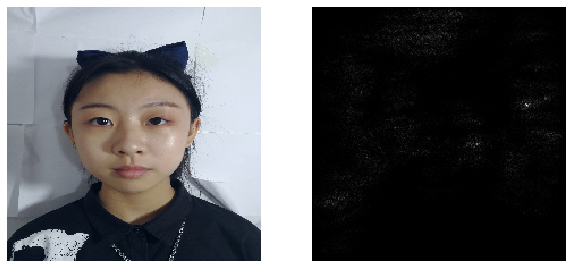

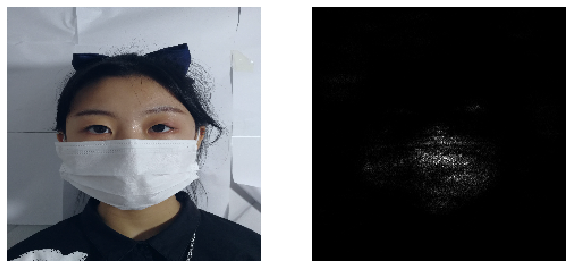

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

input_images = []
saliency_maps = []
  
for _, sample in enumerate(mask_dataset):
  saliency_map = visualize_saliency(sample, model)
  assert list(saliency_map.shape) == [224, 224]
    
  saliency_maps.append(saliency_map.unsqueeze(0))
  input_images.append(sample)

row_list = list(zip(input_images, saliency_maps))
show_images(row_list)

## **Problem 2-3**

The code below implements visualizing grad-CAM. Please fill in  2 **TO DO**s and check the following answers with **calc_answer** functions below.


- **TO DO (5)** : You should fill in function **vis_gradcam**. As comment states, you need to backward score, which is the maximum value of output.

- **TO DO (6)** : You should fill in function **vis_gradcam**. You need to compute the value of **grad-CAM** deinfed in below cells (as well as paper and lecture).



### **Visualizing Grad-CAM**

Proceeding on visualization of saliency map, one can get Grad-CAM, described in Section 3.1 of [2]. Following Section 2 of the paper, one should compute the gradient w.r.t. the image of the unnormalized class score. 

First, compute $\alpha_c^k$ which can be computed with the use of $${\partial y^c \over \partial A^k}$$

where $y^c$ is the score for class $c$, and $A^k$ is the activation of target $k$-th feature map in the target convolutional layer.

Second, take a weighted sum of the forward activation maps $A$ with weights $\alpha_c^k$, and follow it by a ReLU to obtain counterfactual explanations to get $ L_{Grad-CAM}^c $ (i.e, $ ReLU (\sum_k \alpha_c^k A^k) $).



[[2] Selvaraju et al., Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, ICCV 2017](https://arxiv.org/abs/1610.02391)

In [ ]:
save_feat=[]
def hook_feat(module, input, output):
  save_feat.append(output)
  return output

save_grad=[]
def hook_grad(grad):
  """
  get a gradient from intermediate layers (dy / dA).
  See the .register-hook function for usage.
  :return grad: (Variable) gradient dy / dA
  """ 
  save_grad.append(grad)
  return grad

def vis_gradcam(vgg, img):
  """
  Imshow the grad_CAM.
  :param vgg: VGG11Customed model
  :param img: a dog image
  output : plt.imshow(grad_CAM)
  """
  vgg.eval()

  # Reister hook for storing layer activation of the target layer (bn5_2 in backbone)
  vgg.backbone.bn5_2.register_forward_hook(hook_feat)
  
  # Forward pass to hook features
  img = img.unsqueeze(0)
  s = vgg(img)[0]

  # Register hook for storing gradients
  save_feat[0].register_hook(hook_grad)
  
  # Backward score
  '''==========================================================='''
  '''======================== TO DO (5) ========================'''

  y = torch.argmax(s).item()
  s_y = s[y]
  s_y.backward()

  '''==========================================================='''
  '''======================== TO DO (5) ========================'''

  # Compute activation at global-average-pooling layer
  gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
  alpha = gap_layer(save_grad[0][0])
  A = save_feat[0].squeeze()

  # Compute grad_CAM
  relu_layer = torch.nn.ReLU()
  '''==========================================================='''
  '''======================== TO DO (6) ========================'''
  # You may need to use .squeeze() to feed weighted_sum into into relu_layer

  weighted_sum = torch.sum(alpha*A, dim=0)
  grad_CAM = relu_layer(weighted_sum)

  '''==========================================================='''
  '''======================== TO DO (6) ========================'''

  grad_CAM = grad_CAM.unsqueeze(0)
  grad_CAM = grad_CAM.unsqueeze(0)

  # Upscale grad_CAM
  upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')
  grad_CAM = upscale_layer(grad_CAM)
  grad_CAM = grad_CAM/torch.max(grad_CAM)

  # Plotting
  img_np = image_tensor_to_numpy(img)
  if len(img_np.shape) > 3:
    img_np = img_np[0]
  img_np = normalize(img_np)
  
  grad_CAM = grad_CAM.squeeze().detach().numpy()

  plt.figure(figsize=(8, 8))
  plt.imshow(img_np)
  plt.imshow(grad_CAM, cmap='jet', alpha = 0.5)
  plt.show

  return grad_CAM

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


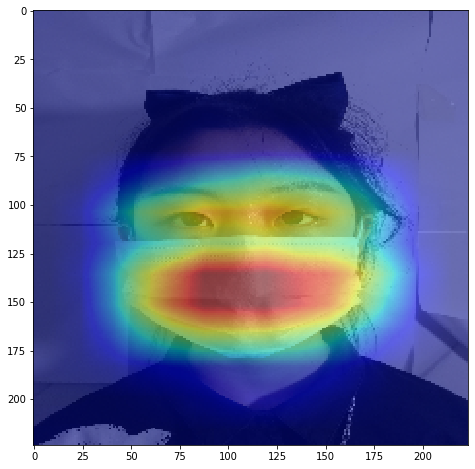

In [ ]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

img = mask_dataset[1]
res = vis_gradcam(model, img)

#### **Discussion**

You may compare the model for **segmentation in Assignment 2** with the result of **grad-CAM** in here. Consider whats in common and whats different. With computation on the **jacobian**s, you may discover something brilliant.

## Answer

The cells below implements simple function that compute the answer for the problem you will be submit on edwith. With proper code filled, you will get an integer answer. 

In [ ]:
def calc_answer_4_1(model):
  """
  Compute overall number of parameters in customed-VGG11
  """
  return get_model_params_num(model)


print(f"The answer for problem (1) is {calc_answer_4_1(model)}")

The answer for problem (1) is 9229575


In [ ]:
def calc_answer_4_2(data):
  """
  Compute data in 143-th row & 78-th column of activation matrix, 
  from 3rd kernel of first conv. layer in pretrained customed-VGG11 model
  with "mask-off" input image
  """
  answer = 0
  
  conv1     = activation_list[0][0]
  conv1_3rd = conv1[2]
  answer    = conv1_3rd[142][77]
  answer    = int(answer * 100 % 100)
  return answer
  
print(f"The answer for problem (2) is {calc_answer_4_2(activation_list)}")

The answer for problem (2) is 35


In [ ]:
def calc_answer_4_3(data):
  """
  Compute (row, column) of maximum data in saliency map of "mask-on" data
  """
  assert len(data) == (2)
  answer = 0

  argmax = np.argmax(data[1][0])
  argm_c = argmax % 224
  argm_r = (argmax-argm_c) / 224
  assert argm_c % 1 == 0
  argm_r = int(argm_r)
  print(argm_r, argm_c.item())

  answer = argm_c + argm_r
  return answer
  
print(f"The answer for problem (3) is {calc_answer_4_3(saliency_maps)}")

133 118
The answer for problem (3) is 251


In [ ]:
def calc_answer_4_4(data):
  """
  Compute (row, column) of maximum data in grad-CAM 
  of image data with "mask-on" input data
  """
  answer = 0

  argmax = np.argmax(data)
  argm_c = argmax % 224
  argm_r = (argmax-argm_c) / 224
  assert argm_c % 1 == 0
  argm_r = int(argm_r)

  answer = argm_c + argm_r
  return answer
  
print(f"The answer for problem (4) is {calc_answer_4_4(res)}")

The answer for problem (4) is 255
